In [121]:
import pandas as pd
import sklearn 
from sklearn import cluster
import matplotlib
import geopandas as gpd
from sklearn.linear_model import LinearRegression
%pylab inline
import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [4]:
# loading taxi & bus data
taxi_ts = 'taxi_timeseries.csv'
bus_ts = 'bus_timeseries.csv'

taxi_ts = pd.read_csv(taxi_ts)
bus_ts = pd.read_csv(bus_ts)

taxi_ts['monthyear'] = taxi_ts.month.apply(str ) + taxi_ts.year.apply(str)

In [5]:
# linear regression
x = range(len(taxi_ts))

intercept = []
slope = []
for bus in taxi_ts.columns[2:6]:
    lr = LinearRegression(fit_intercept=True)
    lr.fit(pd.DataFrame(x), pd.DataFrame(taxi_ts.loc[:,bus]))
    slope.append(lr.coef_[0][0])
    intercept.append(lr.intercept_[0])

In [18]:
# linear regression result
regression_res = pd.DataFrame([taxi_ts.columns[2:6], slope, intercept]).T

regression_res.columns = ['bus', 'slope', 'intercept']
regression_res

,bus,slope,intercept
0,q65,2981.72,38513.6
1,bx15,8622.03,140334
2,b41,8977.6,20974.9
3,q113,418.922,2143.74


In [7]:
# bus data
bus_ts = bus_ts.T
bus_ts.columns = bus_ts.iloc[0,:]
bus_ts = bus_ts.iloc[1:,:]

bus_ts.iloc[:,0] = bus_ts.iloc[:,0].apply(lambda x: int(x.split(',')[0] + x.split(',')[1]))
bus_ts.iloc[:,1] = bus_ts.iloc[:,1].apply(lambda x: int(x.split(',')[0] + x.split(',')[1]))
bus_ts.iloc[:,2] = bus_ts.iloc[:,2].apply(lambda x: int(x.split(',')[0] + x.split(',')[1]))
bus_ts.iloc[:,3] = bus_ts.iloc[:,3].apply(lambda x: int(x.split(',')[0] + x.split(',')[1]))

bus_ts

bus,q113,b41,q65,bx15
2013,11745,32431,20227,26235
2014,9019,30701,20685,32328
2015,4537,28690,21080,30687


In [14]:
taxi_ts.head()

,month,year,q65,bx15,b41,q113,monthyear
0,8,2013,1040,1280,167,13,82013
1,9,2013,7150,7937,1239,96,92013
2,10,2013,16038,44089,3457,406,102013
3,11,2013,27978,112548,9878,657,112013
4,12,2013,49388,156779,25489,2481,122013


In [15]:
bus_ts_norm = bus_ts.copy()
for col in bus_ts_norm.columns:
    bus_ts_norm[col] = (bus_ts_norm[col]-bus_ts_norm[col].mean())/bus_ts_norm[col].std()
    
taxi_ts_norm = taxi_ts.copy()
for col in ['q65', 'bx15', 'b41', 'q113']:
    taxi_ts_norm[col] = (taxi_ts_norm[col]-taxi_ts_norm[col].mean())/taxi_ts_norm[col].std()

In [17]:
taxi_ts_norm.head()

,month,year,q65,bx15,b41,q113,monthyear
0,8,2013,-2.553301,-2.596780,-1.796457,-1.991289,82013
1,9,2013,-2.356367,-2.530231,-1.783311,-1.970618,92013
2,10,2013,-2.069893,-2.168829,-1.756111,-1.893414,102013
3,11,2013,-1.685050,-1.484462,-1.677371,-1.830903,112013
4,12,2013,-0.994974,-1.042296,-1.485933,-1.376643,122013


In [105]:
# linear regression
x = range(len(taxi_ts_norm))
intercept = []
slope = []
score = []
for bus in taxi_ts_norm.columns[2:6]:
    lr = LinearRegression(fit_intercept=True)
    lr.fit(pd.DataFrame(x), pd.DataFrame(taxi_ts_norm.loc[:,bus]))
    slope.append(lr.coef_[0][0])
    intercept.append(lr.intercept_[0])
    score.append(lr.score(pd.DataFrame(x), pd.DataFrame(taxi_ts_norm.loc[:,bus])))
    
res_taxi = pd.DataFrame([taxi_ts_norm.columns[2:6], slope, intercept, score]).T

res_taxi.columns = ['bus', 'slope', 'intercept', 'score']
res_taxi.index = res_taxi['bus']
res_taxi

,bus,slope,intercept,score
bus,,,,
q65,q65,0.0961052,-1.34547,0.669625
bx15,bx15,0.0861923,-1.20669,0.53861
b41,b41,0.110092,-1.54129,0.87872
q113,q113,0.104331,-1.46063,0.78916


In [50]:
np.linspace(-1.6,1.5,10)

array([-1.6       , -1.25555556, -0.91111111, -0.56666667, -0.22222222,
        0.12222222,  0.46666667,  0.81111111,  1.15555556,  1.5       ])

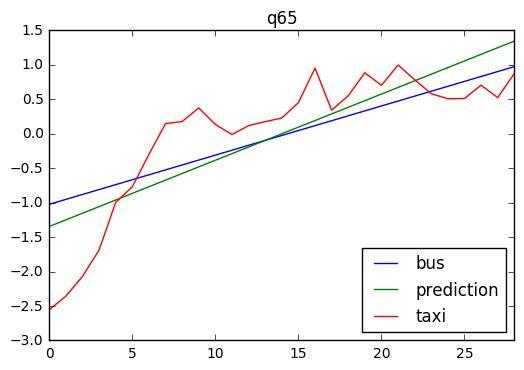

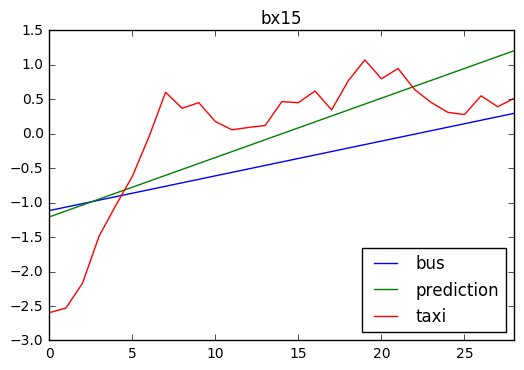

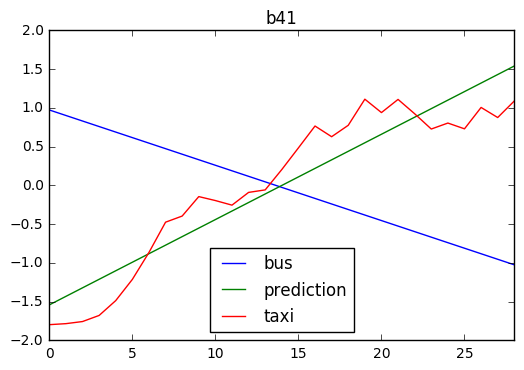

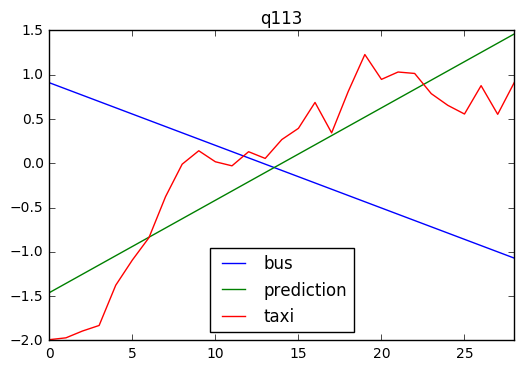

In [55]:
dfs = {}
for bus in res_taxi.index:
    df = taxi_ts_norm[bus]
    pred = np.array(range(len(taxi_ts_norm)))*res_taxi.slope[bus] + res_taxi.intercept[bus]
    bus_ridership = np.linspace(bus_ts_norm.T['2013'][bus], bus_ts_norm.T['2015'][bus], len(taxi_ts_norm))
    df = pd.DataFrame({'taxi': df,'prediction': pred, 'bus': bus_ridership})
    dfs[bus] = df
    df.plot(title=bus)

In [65]:
dfs.keys()

['bx15', 'q65', 'q113', 'b41']

0.733900688581
0.818306035088
-0.888346902913
-0.937400794127


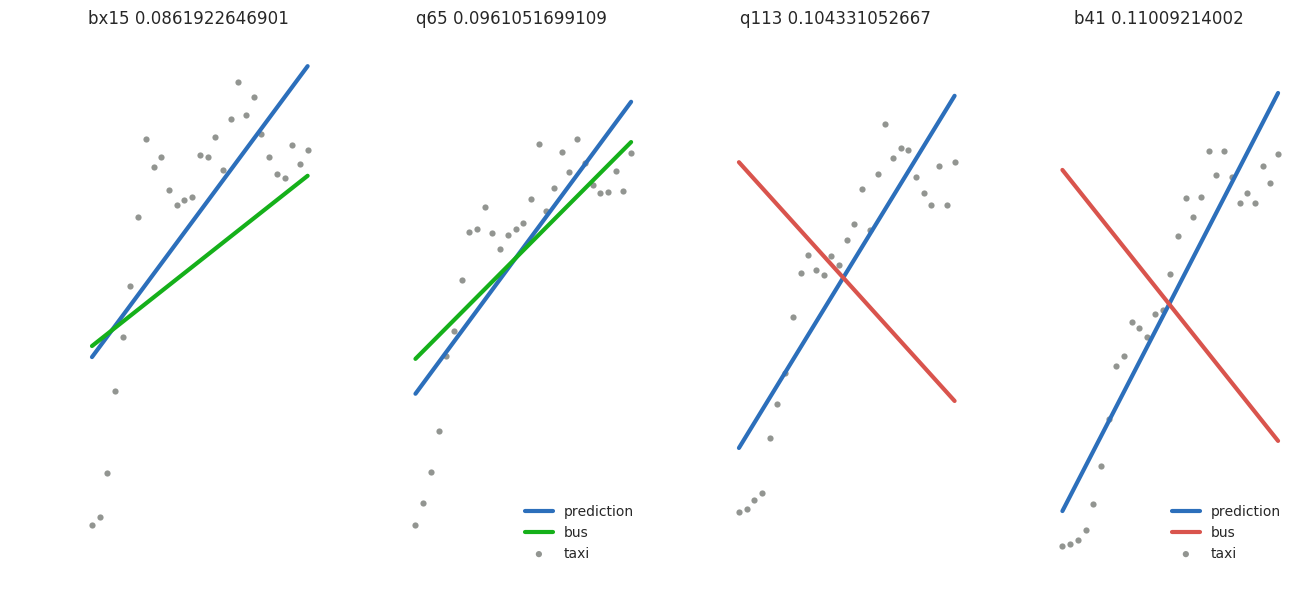

In [147]:
fig = plt.figure(figsize=(16,7))

xplot = range(len(taxi_ts_norm))
for i in range(1,5):
    busname = dfs.keys()[i-1]
    ax = fig.add_subplot(140+i)
    ax.scatter(xplot,dfs[busname]['taxi'],linewidths=0, c=sns.xkcd_rgb["grey"])
    ax.plot(xplot, dfs[busname]['prediction'], sns.xkcd_rgb["medium blue"],linewidth=3)
    if busname in ['bx15', 'q65']:
        ax.plot(xplot, dfs[busname]['bus'], sns.xkcd_rgb["green"], linewidth=3)
    else:
        ax.plot(xplot, dfs[busname]['bus'], sns.xkcd_rgb["pale red"], linewidth=3)
    ax.set_title(busname + ' ' + str(res_taxi['slope'][busname]))
    #ax.set_ylim([-1.5,1.7])
    plt.axis("off")
    if busname in ['b41', 'q65']:
        ax.legend(loc='lower right')
    print np.corrcoef(dfs[busname]['taxi'], dfs[busname]['bus'])[0, 1]

In [48]:
dfs['b41']

,prediction,taxi
0,-1.541290e+00,-1.796457
1,-1.431198e+00,-1.783311
2,-1.321106e+00,-1.756111
3,-1.211014e+00,-1.677371
4,-1.100921e+00,-1.485933
5,-9.908293e-01,-1.212616
6,-8.807371e-01,-0.864777
7,-7.706450e-01,-0.474139
8,-6.605528e-01,-0.394970
9,-5.504607e-01,-0.143922


In [52]:
bus_ts_norm.T['2013']

bus
q113    0.909838
b41     0.974047
q65    -1.023689
bx15   -1.114911
Name: 2013, dtype: float64

In [8]:
# months number in each year 
yr_13 = len(taxi_ts[taxi_ts.year == 2013])
yr_14 = len(taxi_ts[taxi_ts.year == 2014])
yr_15 = len(taxi_ts[taxi_ts.year == 2015])

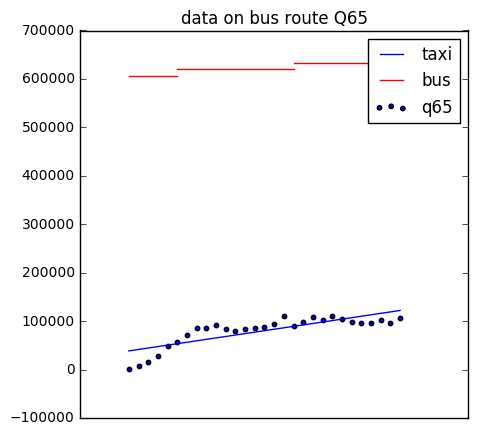

In [9]:
plt.figure(figsize = [5,5])
x_plot = np.linspace(0, 28, 1000)
y_plot = regression_res.slope[0] * x_plot + regression_res.intercept[0]
plt.plot(x_plot, y_plot, label = 'taxi')
plt.scatter(x, taxi_ts.q65, s = 10)
plt.plot(np.linspace(0, yr_13, 200), [bus_ts.loc['2013', 'q65'] * 30] * 200, color = 'r', label = 'bus')
plt.plot(np.linspace(yr_13, yr_13 + yr_14, 200), [bus_ts.loc['2014', 'q65'] * 30] * 200, color = 'r')
plt.plot(np.linspace(yr_13 + yr_14, yr_13 + yr_14 + yr_15, 200), [bus_ts.loc['2015', 'q65'] * 30] * 200, color = 'r')

#plt.xlim(0,30)
plt.xticks([])
plt.legend()
plt.title('data on bus route Q65')
plt.savefig('q65')

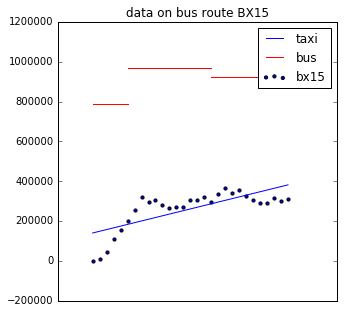

In [255]:
plt.figure(figsize = [5,5])
x_plot = np.linspace(0, 28, 1000)
y_plot = regression_res.slope[1] * x_plot + regression_res.intercept[1]
plt.plot(x_plot, y_plot, label = 'taxi')
plt.scatter(x, taxi_ts.bx15, s = 10)
plt.plot(np.linspace(0, yr_13, 200), [bus_ts.loc['2013', 'bx15'] * 30] * 200, color = 'r', label = 'bus')
plt.plot(np.linspace(yr_13, yr_13 + yr_14, 200), [bus_ts.loc['2014', 'bx15'] * 30] * 200, color = 'r')
plt.plot(np.linspace(yr_13 + yr_14, yr_13 + yr_14 + yr_15, 200), [bus_ts.loc['2015', 'bx15'] * 30] * 200, color = 'r')

#plt.xlim(0,30)
plt.xticks([])
plt.legend()
plt.title('data on bus route BX15')
plt.savefig('bx15')

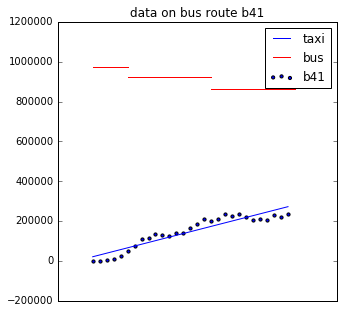

In [257]:
plt.figure(figsize = [5,5])
x_plot = np.linspace(0, 28, 1000)
y_plot = regression_res.slope[2] * x_plot + regression_res.intercept[2]
plt.plot(x_plot, y_plot, label = 'taxi')
plt.scatter(x, taxi_ts.b41, s = 10)
plt.plot(np.linspace(0, yr_13, 200), [bus_ts.loc['2013', 'b41'] * 30] * 200, color = 'r', label = 'bus')
plt.plot(np.linspace(yr_13, yr_13 + yr_14, 200), [bus_ts.loc['2014', 'b41'] * 30] * 200, color = 'r')
plt.plot(np.linspace(yr_13 + yr_14, yr_13 + yr_14 + yr_15, 200), [bus_ts.loc['2015', 'b41'] * 30] * 200, color = 'r')

#plt.xlim(0,30)
plt.xticks([])
plt.legend()
plt.title('data on bus route b41')
plt.savefig('B41')

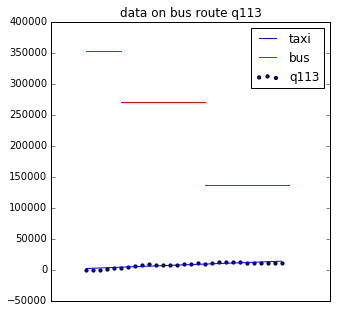

In [258]:
plt.figure(figsize = [5,5])
x_plot = np.linspace(0, 28, 1000)
y_plot = regression_res.slope[3] * x_plot + regression_res.intercept[3]
plt.plot(x_plot, y_plot, label = 'taxi')
plt.scatter(x, taxi_ts.q113, s = 10)
plt.plot(np.linspace(0, yr_13, 200), [bus_ts.loc['2013', 'q113'] * 30] * 200, color = 'r', label = 'bus')
plt.plot(np.linspace(yr_13, yr_13 + yr_14, 200), [bus_ts.loc['2014', 'q113'] * 30] * 200, color = 'r')
plt.plot(np.linspace(yr_13 + yr_14, yr_13 + yr_14 + yr_15, 200), [bus_ts.loc['2015', 'q113'] * 30] * 200, color = 'r')

#plt.xlim(0,30)
plt.xticks([])
plt.legend()
plt.title('data on bus route q113')
plt.savefig('q113')